# Single clique dynamics

In [ ]:
# run this notebook with Python3 kernel

In [1]:
# fileName

fileName = 'eg_single-clique' 

In [2]:
try:
    import pyNN.spiNNaker as sim
except ModuleNotFoundError:
    import pyNN.brian2 as sim
    
from pyNN import space 
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pickle
import pandas as pd
import seaborn as sns
import time
import datetime
import json
import warnings
warnings.filterwarnings('ignore')
import python_utils as pu
%matplotlib inline

savePath = f'../outputs/' # remember to create the folder if not already present (mkdir ./notebooks/outputs)
dt_string = datetime.datetime.today().isoformat() # ISO8601 ! :-)
tag = dt_string 
saveName = f'{savePath}{fileName}-{tag}'
print(saveName)
PARS={}


INFO       Cache size for target 'cython': 1184156984 MB.
You can call clear_cache('cython') to delete all files from the cache or manually delete files in the '/home/bbpnrsoa/.cython/brian_extensions' directory. [brian2]


../outputs/eg_single-clique-2023-11-23T19:54:01.757514


# simulation settings

In [3]:
PARS={}
PARS['dt']=1 #ms
PARS['min_delay']=1 #ms
PARS['max_delay']=100 #ms
PARS['simtime']=100 #ms

sim.setup(
        timestep=PARS['dt'],
        min_delay=PARS['min_delay'],
        max_delay=PARS['max_delay'])

simtime = PARS['simtime']

# define the network with default parameters

In [4]:
# print(sim.IF_cond_exp.default_parameters)

cell0 = sim.Population(1, 
                      sim.IF_cond_exp(), 
                      label='cell0')

cell1 = sim.Population(1, 
                      sim.IF_cond_exp(), 
                      label='cell1')

cell0.record(['v', 'gsyn_exc', 'gsyn_inh', 'spikes'])
cell1.record(['v', 'gsyn_exc', 'gsyn_inh', 'spikes'])

pops=dict(cell0=cell0, 
          cell1=cell1)

pops.keys()

dict_keys(['cell0', 'cell1'])

# define connections

In [5]:
ge=1 # nS
gi=1 # nS
d=1 # delay ms

connection = sim.Projection(cell0, 
                            cell1,
                            sim.OneToOneConnector(),
                            sim.StaticSynapse(weight=ge, delay=d),
                            receptor_type='excitatory'),

connection = sim.Projection(cell1, 
                            cell0,
                            sim.OneToOneConnector(),
                            sim.StaticSynapse(weight=gi, delay=d),
                            receptor_type='inhibitory'),


# input

In [6]:
#pulse = sim.DCSource(amplitude=1, start=20.0, stop=30.0)
pulse = sim.StepCurrentSource(times=[30,40],
                              amplitudes=[10,0,])
pulse.inject_into(cell0)
pulse.record()


# simulation run

In [7]:
tic = time.time()
sim.run(simtime)
toc = time.time() - tic
print(f'simulation time: {toc} [s]')

INFO       No numerical integration method specified for group 'neurongroup_1', using method 'euler' (took 0.02s, trying other methods took 0.08s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup', using method 'euler' (took 0.01s, trying other methods took 0.03s). [brian2.stateupdaters.base.method_choice]


simulation time: 0.32552409172058105 [s]


# save and get results

In [8]:
stateVars = {}
for pop in pops.keys():
    for recording in ['v', 'gsyn_inh', 'gsyn_exc', 'spikes']:
        pops[pop].write_data(f'{saveName}-{recording}.pkl')
        stateVars[pop]=pops[pop].get_data()

stateVars.keys()
results = pu.recover_results(stateVars)
results.keys()

cell0
v
gsyn_exc
gsyn_inh
cell1
v
gsyn_exc
gsyn_inh


dict_keys([('cell0', 'v'), ('cell0', 'gsyn_exc'), ('cell0', 'gsyn_inh'), ('cell0', 'spikes'), ('cell1', 'v'), ('cell1', 'gsyn_exc'), ('cell1', 'gsyn_inh'), ('cell1', 'spikes')])

# plots

In [9]:
timeVector = np.linspace(0,PARS['simtime'], np.int(PARS['simtime']/PARS['dt'])+1)

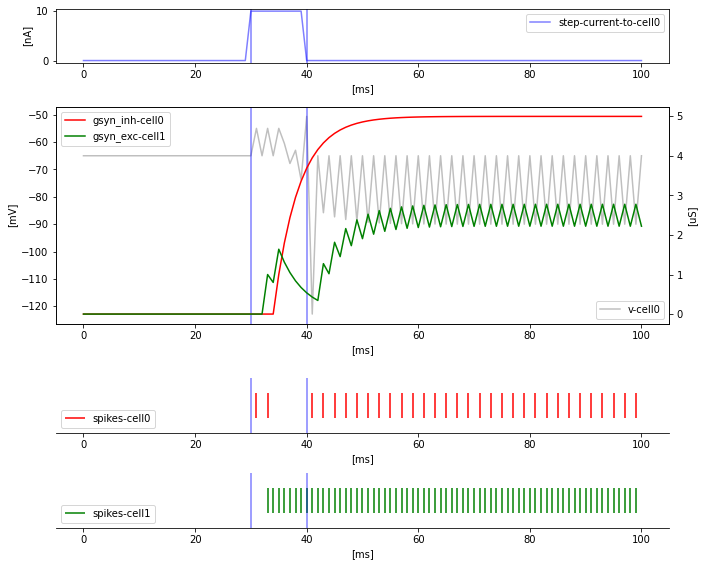

In [17]:
fig, ax = plt.subplots(1,1,figsize=(11, 4))
#ax = ax.flatten()
#fig.tight_layout(pad=5)

ax.plot(timeVector, results['cell0', 'v'], label='v-cell0', color='k', alpha=0.25)
axR=ax.twinx()
axR.plot(timeVector, results['cell0', 'gsyn_inh'], label='gsyn_inh-cell0', color='r')
axR.plot(timeVector, results['cell1', 'gsyn_exc'], label='gsyn_exc-cell1', color='g')
axR.set_ylabel('[uS]')
axR.legend()
ax.set_xlabel('[ms]')
ax.set_ylabel('[mV]')
ax.legend(loc='lower right')
axU=ax.inset_axes([0,1.2, 1, 0.25])
axU.plot(timeVector, pulse.get_data(), label='step-current-to-cell0', color='b', alpha=0.5)
axU.axvline(30, color='b',alpha=0.5)
axU.axvline(40, color='b',alpha=0.5)
axU.set_ylabel('[nA]')
axU.set_xlabel('[ms]')
axU.legend()
ax.axvline(30, color='b',alpha=0.5)
ax.axvline(40, color='b',alpha=0.5)

axL=ax.inset_axes([0,-0.5, 1, 0.25])
axL.eventplot(results['cell0', 'spikes'], color='r', alpha=1, label='spikes-cell0')
axL.set_xlim(ax.get_xlim())
axL.axvline(30, color='b',alpha=0.5)
axL.axvline(40, color='b',alpha=0.5)
axLL=axL.inset_axes([0,-1.75, 1, 1])
axLL.eventplot(results['cell1', 'spikes'], color='g', alpha=1, label='spikes-cell1')
axLL.set_xlim(ax.get_xlim())
axLL.axvline(30, color='b',alpha=0.5)
axLL.axvline(40, color='b',alpha=0.5)
axLL.legend(loc='lower left')
axL.legend(loc='lower left')
axL.set_xlabel('[ms]')
axLL.set_xlabel('[ms]')

axLL.spines['left'].set_visible(False)
axLL.spines['right'].set_visible(False)
axLL.spines['top'].set_visible(False)
axL.spines['left'].set_visible(False)
axL.spines['right'].set_visible(False)
axL.spines['top'].set_visible(False)
axL.set_yticklabels(' ')
axL.set_yticks([])
axLL.set_yticklabels(' ')
axLL.set_yticks([])

#axLLL=axL.inset_axes([0,-3,  1, 1])
#balanceCell0=results['cell0', 'gsyn_exc']/results['cell0', 'gsyn_inh']
#balanceCell1=results['cell1', 'gsyn_exc']/results['cell1', 'gsyn_inh']
#axLLL.plot(timeVector, balanceCell0)
#axLLL.plot(timeVector, balanceCell1)

fig.savefig(f'{saveName}.jpeg', dpi=70, bbox_inches='tight', facecolor='white')